In [4]:
#Magic and Console Commands
%load_ext tensorboard
!pip install keras-metrics

#System Libraries
import os
import datetime 
import sys 
from pathlib import Path

#Standard Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import wordcloud

#Image Specific Libraries
import warnings
warnings.filterwarnings("ignore")

#Tensorflow and Keras Libraries
import tensorflow as tf
import keras
from keras import metrics
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras_metrics import binary_average_recall, binary_f1_score, binary_false_negative, binary_false_positive, binary_precision, binary_recall, binary_true_negative, binary_true_positive
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications import vgg16
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split


#Scikit Lean Libraries
from sklearn.model_selection import train_test_split
model = tf.keras.models.load_model('saved_model.pb')
#Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/spam.csv', encoding = 'latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
df.rename(columns = {'v1': 'label', "v2": 'text'}, inplace=True)

In [8]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

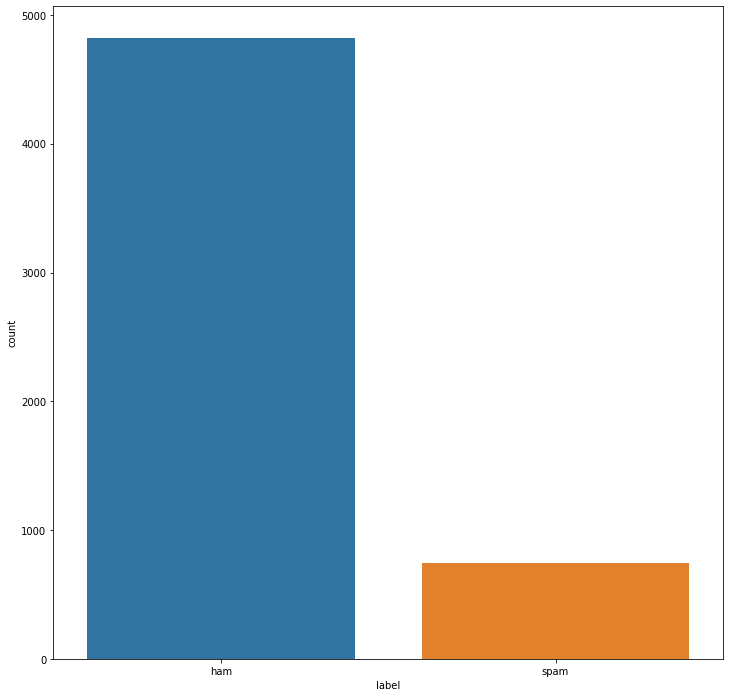

In [9]:
plt.figure(figsize=(12,12))

sns.countplot(df['label'])
plt.show();

In [10]:
df['label'] = df['label'].map({'spam': 1, "ham":0})

In [11]:
df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [12]:
df_ham = df[df['label']==0]
df_spam = df[df['label']==1]

In [13]:
def show_wordcloud(df, title):
    text = ' '.join(df['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

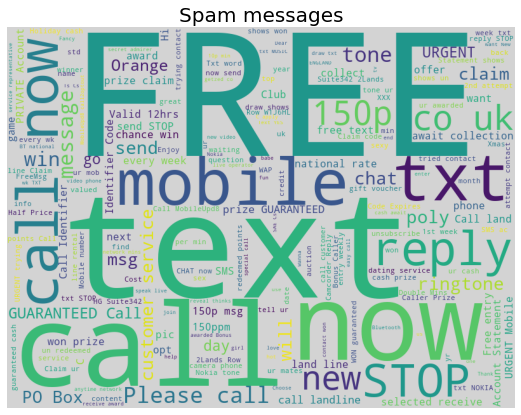

In [14]:
show_wordcloud(df_spam, "Spam messages")

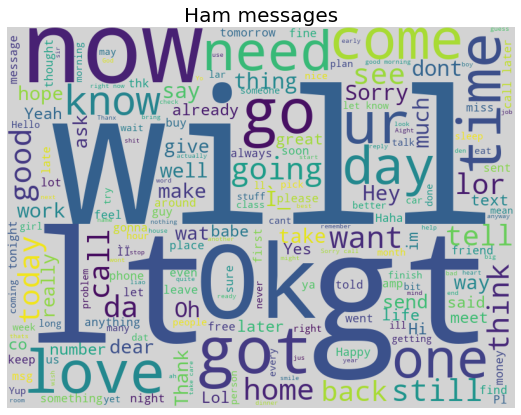

In [15]:
show_wordcloud(df_ham, "Ham messages")

In [16]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=808)

t = Tokenizer()
t.fit_on_texts(X_train)
encode_train = t.texts_to_sequences(X_train)
encode_test = t.texts_to_sequences(X_test)

In [17]:
print(encode_train[0:2])

[[232, 106, 32, 797, 29, 567, 92, 15, 72, 4, 2003, 12, 5, 350, 223], [35, 538, 629, 130, 284, 858]]


In [47]:
max_length = 10
padded_train = pad_sequences(encode_train, maxlen=max_length, padding ='post')
padded_test = pad_sequences(encode_test, maxlen=max_length, padding ='post')

In [19]:
print(padded_train)

[[   5  319   45 ...  134  195  143]
 [3280    6   23 ...    0    0    0]
 [  56  769   79 ...    1    2  189]
 ...
 [  26  618 2330 ... 3110   22 2330]
 [2514   10   99 ... 1917    6 4976]
 [   1  102  531 ...    0    0    0]]


In [29]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

In [30]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'i', 'to', 'you']

In [31]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-04-05 15:25:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-05 15:25:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-05 15:25:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [35]:
path_to_glove_file = os.path.join(
    '/content/glove.6B.100d.txt'
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [36]:
num_tokens = len(voc) + 1
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 5774 words (2589 misses)


In [92]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=max_length,
    trainable=False,
)

In [95]:
vocab_size = len(t.word_index) + 1
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
# model.add(layers.Conv1D(128,5, padding = 'same', activation='relu'))
# model.add(layers.Conv1D(128,5, padding = 'same', activation='relu'))
# model.add(layers.AveragePooling1D(2))
# model.add(layers.BatchNormalization(axis = 1))
# model.add(layers.Conv1D(128,5, padding = 'same', activation='relu'))
# model.add(layers.Conv1D(128,5, padding = 'same', activation='relu'))
# model.add(layers.AveragePooling1D(2))
# model.add(layers.BatchNormalization(axis = 1))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 10, 24)            188784    
_________________________________________________________________
flatten_12 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 500)               120500    
_________________________________________________________________
dense_49 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_51 (Dense)             (None, 1)               

In [96]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model

model.fit(x=padded_train,
         y=y_train,
         epochs=100,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/100
140/140 [==============================] - 2s 8ms/step - loss: 0.2805 - accuracy: 0.8952 - val_loss: 0.0897 - val_accuracy: 0.9749
Epoch 2/100
140/140 [==============================] - 1s 7ms/step - loss: 0.0438 - accuracy: 0.9878 - val_loss: 0.1219 - val_accuracy: 0.9776
Epoch 3/100
140/140 [==============================] - 1s 8ms/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 0.1272 - val_accuracy: 0.9821
Epoch 4/100
140/140 [==============================] - 1s 8ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.2006 - val_accuracy: 0.9821
Epoch 5/100
140/140 [==============================] - 1s 8ms/step - loss: 4.9342e-05 - accuracy: 1.0000 - val_loss: 0.3344 - val_accuracy: 0.9794
Epoch 6/100
140/140 [==============================] - 1s 8ms/step - loss: 9.3889e-05 - accuracy: 1.0000 - val_loss: 0.3597 - val_accuracy: 0.9794
Epoch 7/100
140/140 [==============================] - 1s 8ms/step - loss: 7.0783e-07 - accuracy: 1.0000 - val_loss: 0.3913 - val_accu

In [88]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = round(accuracy_score(y_true, y_pred), 2)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False,xticklabels=['ham', 'spam'],
               yticklabels=['ham', 'spam'])
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [81]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

In [84]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       951
           1       0.97      0.90      0.93       164

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.98


0.98

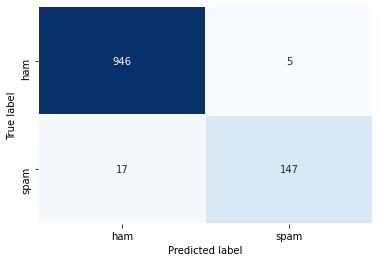

In [89]:
plot_confusion_matrix(y_test, preds)

In [90]:
model.save("/content/drive/MyDrive/Datasets/Models/spam_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/Models/spam_model/assets


In [91]:
with open('/content/drive/MyDrive/Datasets/Models/spam_model/tokenizer.pkl', 'wb') as output:
   pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

In [107]:
df = pd.DataFrame({
    
    'Text': X_test.values,
    'Actual': y_test,
    'Predictions': preds.flatten()
})
df

,Text,Actual,Predictions
1206,"As a SIM subscriber, you are selected to recei...",1,1
4470,Wa... U so efficient... Gee... Thanx...,0,0
1215,that would be good Û_ I'll phone you tomo lun...,0,0
4288,"Okay, good, no problem, and thanx!",0,0
932,So do you have samus shoulders yet,0,0
...,...,...,...
2264,Ok . . now i am in bus. . If i come soon i wil...,0,0
934,Dear Matthew please call 09063440451 from a la...,1,1
3618,8007 25p 4 Alfie Moon's Children in Need song ...,1,1
3009,Imagine Life WITHOUT ME... see.. How fast u ar...,0,0


In [109]:
mis_class = df[df['Actual'] != df['Predictions']]

In [111]:
mis_class

,Text,Actual,Predictions
5443,You have won a guaranteed 32000 award or maybe...,1,0
4752,Cashbin.co.uk (Get lots of cash this weekend!)...,1,0
3748,Dear Voucher Holder 2 claim your 1st class air...,1,0
1790,Am not working but am up to eyes in philosophy...,0,1
2339,Cheers for the message Zogtorius. IåÕve been s...,0,1
855,Talk sexy!! Make new friends or fall in love i...,1,0
95,Your free ringtone is waiting to be collected....,1,0
4254,Block Breaker now comes in deluxe format with ...,1,0
4512,Money i have won wining number 946 wot do i do...,1,0
4364,Ujhhhhhhh computer shipped out with address to...,0,1


In [112]:
s_model = tf.keras.models.load_model("/content/drive/MyDrive/Datasets/Models/spam_model")
with open('/content/drive/MyDrive/Datasets/Models/spam_model/tokenizer.pkl', 'rb') as input:
    tokenizer = pickle.load(input)


In [122]:
def spam_check(sms):
  sms=[sms]
  sms_proc = tokenizer.texts_to_sequences(sms)
  sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
  pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
  print(pred)

1


['lol']